In [5]:
import pandas as pd
import joblib
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge


In [6]:
df = pd.read_csv("../data/support_tickets.csv", parse_dates=["created_at"])

daily = (
    df.groupby(df["created_at"].dt.date)
      .size()
      .reset_index(name="ticket_count")
)

daily.rename(columns={"created_at": "date"}, inplace=True)
daily["date"] = pd.to_datetime(daily["date"])

daily["day_of_week"] = daily["date"].dt.weekday
daily["is_weekend"] = daily["day_of_week"].isin([5, 6]).astype(int)
daily["lag_1"] = daily["ticket_count"].shift(1)
daily["lag_7"] = daily["ticket_count"].shift(7)
daily["rolling_7"] = daily["ticket_count"].rolling(7).mean()

daily = daily.dropna()


In [7]:
X = daily[["day_of_week", "is_weekend", "lag_1", "lag_7", "rolling_7"]]
y = daily["ticket_count"]


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [9]:
rf = RandomForestRegressor(random_state=42)

rf_params = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}

rf_grid = GridSearchCV(
    rf,
    rf_params,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_


In [10]:
svm = SVR()

svm_params = {
    "C": [1, 10, 50],
    "epsilon": [0.1, 1],
    "kernel": ["rbf"]
}

svm_grid = GridSearchCV(
    svm,
    svm_params,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

svm_grid.fit(X_train, y_train)
best_svm = svm_grid.best_estimator_


In [11]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)


,"alpha alpha: {float, ndarray of shape (n_targets,)}, default=1.0Constant that multiplies the L2 term, controlling regularizationstrength. `alpha` must be a non-negative float i.e. in `[0, inf)`.When `alpha = 0`, the objective is equivalent to ordinary leastsquares, solved by the :class:`LinearRegression` object. For numericalreasons, using `alpha = 0` with the `Ridge` object is not advised.Instead, you should use the :class:`LinearRegression` object.If an array is passed, penalties are assumed to be specific to thetargets. Hence they must correspond in number.",1.0
,"fit_intercept fit_intercept: bool, default=TrueWhether to fit the intercept for this model. If setto false, no intercept will be used in calculations(i.e. ``X`` and ``y`` are expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"max_iter max_iter: int, default=NoneMaximum number of iterations for conjugate gradient solver.For 'sparse_cg' and 'lsqr' solvers, the default value is determinedby scipy.sparse.linalg. For 'sag' solver, the default value is 1000.For 'lbfgs' solver, the default value is 15000.",None
,"tol tol: float, default=1e-4The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for each solver:- 'svd': `tol` has no impact.- 'cholesky': `tol` has no impact.- 'sparse_cg': norm of residuals smaller than `tol`.- 'lsqr': `tol` is set as atol and btol of scipy.sparse.linalg.lsqr, which control the norm of the residual vector in terms of the norms of matrix and coefficients.- 'sag' and 'saga': relative change of coef smaller than `tol`.- 'lbfgs': maximum of the absolute (projected) gradient=max|residuals| smaller than `tol`... versionchanged:: 1.2 Default value changed from 1e-3 to 1e-4 for consistency with other linear models.",0.0001
,"solver solver: {'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'}, default='auto'Solver to use in the computational routines:- 'auto' chooses the solver automatically based on the type of data.- 'svd' uses a Singular Value Decomposition of X to compute the Ridge coefficients. It is the most stable solver, in particular more stable for singular matrices than 'cholesky' at the cost of being slower.- 'cholesky' uses the standard :func:`scipy.linalg.solve` function to obtain a closed-form solution.- 'sparse_cg' uses the conjugate gradient solver as found in :func:`scipy.sparse.linalg.cg`. As an iterative algorithm, this solver is more appropriate than 'cholesky' for large-scale data (possibility to set `tol` and `max_iter`).- 'lsqr' uses the dedicated regularized least-squares routine :func:`scipy.sparse.linalg.lsqr`. It is the fastest and uses an iterative procedure.- 'sag' uses a Stochastic Average Gradient descent, and 'saga' uses its improved, unbiased version named SAGA. Both methods also use an iterative procedure, and are often faster than other solvers when both n_samples and n_features are large. Note that 'sag' and 'saga' fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from :mod:`sklearn.preprocessing`.- 'lbfgs' uses L-BFGS-B algorithm implemented in :func:`scipy.optimize.minimize`. It can be used only when `positive` is True.All solvers except 'svd' support both dense and sparse data. However, only'lsqr', 'sag', 'sparse_cg', and 'lbfgs' support sparse input when`fit_intercept` is True... versionadded:: 0.17 Stochastic Average Gradient descent solver... versionadded:: 0.19 SAGA solver.",'auto'
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive.Only 'lbfgs' solver is supported in this case.",False
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag' or 'saga' to shuffle the data.See :term:`Glossary ` for details... versionadded:: 0.17 `random_state` to support Stochastic Average Gradient.",None


In [12]:
models = {
    "RandomForest": best_rf,
    "SVM": best_svm,
    "Ridge": ridge
}

for name, model in models.items():
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    print(name, "MAE:", round(mae, 2))


RandomForest MAE: 9.49
SVM MAE: 7.93
Ridge MAE: 8.23


In [13]:
ensemble = VotingRegressor(
    estimators=[
        ("rf", best_rf),
        ("svm", best_svm),
        ("ridge", ridge)
    ]
)

ensemble.fit(X_train, y_train)


,"estimators estimators: list of (str, estimator) tuplesInvoking the ``fit`` method on the ``VotingRegressor`` will fit clonesof those original estimators that will be stored in the class attribute``self.estimators_``. An estimator can be set to ``'drop'`` using:meth:`set_params`... versionchanged:: 0.21 ``'drop'`` is accepted. Using None was deprecated in 0.22 and support was removed in 0.24.","[('rf', ...), ('svm', ...), ...]"
,"weights weights: array-like of shape (n_regressors,), default=NoneSequence of weights (`float` or `int`) to weight the occurrences ofpredicted values before averaging. Uses uniform weights if `None`.",None
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for ``fit``.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting will be printed as itis completed... versionadded:: 0.23",False
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",5
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_f

In [15]:
ensemble_preds = ensemble.predict(X_test)

mae = mean_absolute_error(y_test, ensemble_preds)
mse = mean_squared_error(y_test, ensemble_preds)
rmse = mse ** 0.5
mae, rmse


(8.249842791081665, 10.13528278461788)

In [16]:
joblib.dump(ensemble, "../models/load_model.pkl")


['../models/load_model.pkl']

In [17]:
os.path.exists("../models/load_model.pkl")


True

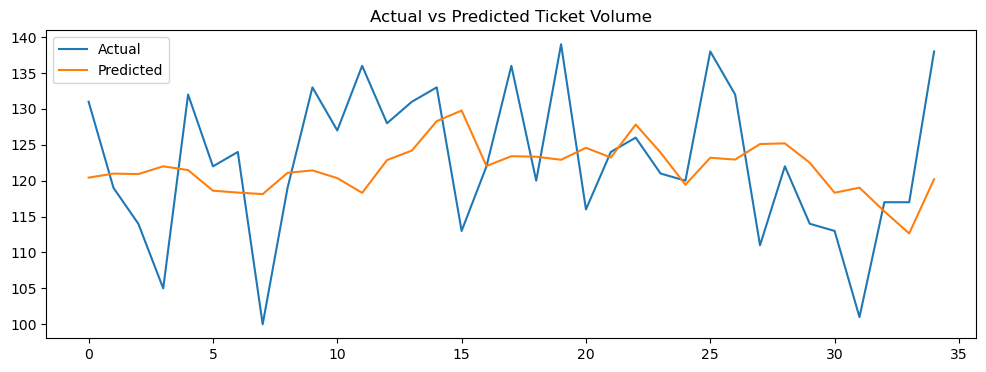

In [18]:
import matplotlib.pyplot as plt

# Predict on test set
test_preds = ensemble.predict(X_test)

# Plot actual vs predicted
plt.figure(figsize=(12,4))
plt.plot(y_test.values, label="Actual")
plt.plot(test_preds, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Ticket Volume")
plt.show()


In [19]:
mape = (abs(y_test - test_preds) / y_test).mean() * 100
mape


6.810264297003914